# 06__tf_tissue_sp
# calculating tissue specificity of TFs (across HepG2, HeLa, and K562)

in this notebook, i calculate the tissue specificity of TFs across the 3 cell types in our MPRAs using ENCODE RNA-seq data. then, i correlate motif coverage (# bp covered and maximum coverage) as well as average TF specificity with MPRA activities and specificities.

note: the FIMO mappings and coverage calculations were done separately (see methods)

------

figures in this notebook:
- **Fig 3C**: KDE plot of correlations of MPRA activity & specificity with each of the 3 metrics

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from itertools import chain
from decimal import Decimal
from scipy import stats
from scipy import signal
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
expr_f = "../../misc/03__rna_seq_expr/Expression.all.cells.txt"
tf_map_f = "../../misc/04__jaspar_id_map/2018_03_09_gencode_jaspar_curated.txt"
fimo_f = "../../misc/05__fimo/pool1_fimo_map.txt"
cov_map_f = "../../misc/05__fimo/seqID_nFimoMotifs_Coverage.txt"

In [4]:
index_dir = "../../data/00__index"
index_f = "%s/tss_oligo_pool.index.txt" % index_dir

In [5]:
hepg2_activ_f = "../../data/02__activs/POOL1__pMPRA1__HepG2__activities_per_element.txt"
hela_activ_f = "../../data/02__activs/POOL1__pMPRA1__HeLa__activities_per_element.txt"
k562_activ_f = "../../data/02__activs/POOL1__pMPRA1__K562__activities_per_element.txt"

## 1. import data

In [6]:
tf_map = pd.read_table(tf_map_f)
tf_map.head()

,motif_id,motif_name,Gene ID,comment
0,MA0002.2,RUNX1,ENSG00000159216,NaN
1,MA0003.3,TFAP2A,ENSG00000137203,NaN
2,MA0007.3,Ar,ENSG00000169083,Mus musculus; human ortholog selected
3,MA0009.2,T,ENSG00000164458,NaN
4,MA0014.2,PAX5,ENSG00000196092,NaN


In [7]:
expr = pd.read_table(expr_f)
expr.head()

,gene_id,A549,GM12878,H1-hESC,HUVEC,HeLa-S3,HepG2,IMR90,K562,MCF-7,NHEK,SK-N-SH
0,ENSG00000000003.10,31.920162,0.012392,39.989468,47.588514,34.921604,46.439177,10.383956,0.242817,24.534779,13.546740,15.400938
1,ENSG00000000005.5,0.000000,0.000000,0.729510,0.000000,0.000000,0.052697,0.000000,0.000000,0.012272,0.000000,0.000000
2,ENSG00000000419.8,34.321019,54.130236,22.474711,22.001707,80.122759,58.227585,42.266614,52.947538,119.129811,50.828462,64.445213
3,ENSG00000000457.9,4.715796,9.902367,2.222304,2.693052,8.641308,2.948341,3.283652,6.761766,7.120837,4.792727,6.164291
4,ENSG00000000460.12,11.382585,20.353400,12.625342,6.522418,34.807272,6.199940,3.842012,27.191509,15.206148,5.591343,3.786800


In [8]:
fimo = pd.read_table(fimo_f, sep="\t")
fimo.columns = ["motif", "unique_id", "start", "end", "strand", "score", "pval", "qval", "seq"]
fimo.head()

,motif,unique_id,start,end,strand,score,pval,qval,seq
0,ZNF263,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__chr9:...,60,80,-,29.2449,9.790000e-13,2.160000e-07,GGAGGAGGAGGAGGAGGGGGA
1,ZNF263,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,60,80,-,29.2449,9.790000e-13,2.160000e-07,GGAGGAGGAGGAGGAGGGGGA
2,ZNF263,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,57,77,-,29.0000,1.740000e-12,2.160000e-07,GGAGGAGGAGGAGGGGGAGGA
3,ZNF263,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__chr9:...,57,77,-,29.0000,1.740000e-12,2.160000e-07,GGAGGAGGAGGAGGGGGAGGA
4,ZNF263,FLIPPED__Enhancer.flip.antisense__chr19:185263...,32,52,+,28.7347,2.680000e-12,2.160000e-07,GGAGGAGGAAGAGGAGGAGGG


In [9]:
cov_map = pd.read_table(cov_map_f)
cov_map.head()

,seqID,maxCov,numMotifs,numBPcovered,fractionBPcovered
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,5,16,99,0.868421
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,6,10,45,0.394737
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,24,53,101,0.885965
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,12,24,84,0.736842
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,9,13,54,0.473684


In [10]:
index = pd.read_table(index_f, sep="\t")
index_elem = index[["element", "oligo_type", "unique_id", "dupe_info", "SNP", "seq_name"]]
index_elem = index_elem.drop_duplicates()

In [11]:
hepg2_activ = pd.read_table(hepg2_activ_f, sep="\t")
hela_activ = pd.read_table(hela_activ_f, sep="\t")
k562_activ = pd.read_table(k562_activ_f, sep="\t")

In [12]:
hepg2_reps = [x for x in hepg2_activ.columns if "rna" in x]
hela_reps = [x for x in hela_activ.columns if "rna" in x]
k562_reps = [x for x in k562_activ.columns if "rna" in x]

## 2. find expr of TFs in HeLa, HepG2, K562

In [13]:
expr["ensembl_id"] = expr["gene_id"].str.split(".", expand=True)[0]
expr.head()

,gene_id,A549,GM12878,H1-hESC,HUVEC,HeLa-S3,HepG2,IMR90,K562,MCF-7,NHEK,SK-N-SH,ensembl_id
0,ENSG00000000003.10,31.920162,0.012392,39.989468,47.588514,34.921604,46.439177,10.383956,0.242817,24.534779,13.546740,15.400938,ENSG00000000003
1,ENSG00000000005.5,0.000000,0.000000,0.729510,0.000000,0.000000,0.052697,0.000000,0.000000,0.012272,0.000000,0.000000,ENSG00000000005
2,ENSG00000000419.8,34.321019,54.130236,22.474711,22.001707,80.122759,58.227585,42.266614,52.947538,119.129811,50.828462,64.445213,ENSG00000000419
3,ENSG00000000457.9,4.715796,9.902367,2.222304,2.693052,8.641308,2.948341,3.283652,6.761766,7.120837,4.792727,6.164291,ENSG00000000457
4,ENSG00000000460.12,11.382585,20.353400,12.625342,6.522418,34.807272,6.199940,3.842012,27.191509,15.206148,5.591343,3.786800,ENSG00000000460


In [14]:
tf_expr = tf_map.merge(expr, left_on="Gene ID", right_on="ensembl_id", how="left")
tf_expr.head()

,motif_id,motif_name,Gene ID,comment,gene_id,A549,GM12878,H1-hESC,HUVEC,HeLa-S3,HepG2,IMR90,K562,MCF-7,NHEK,SK-N-SH,ensembl_id
0,MA0002.2,RUNX1,ENSG00000159216,NaN,ENSG00000159216.14,2.424524,0.534881,0.675734,6.063154,1.859569,4.693606,38.174505,9.631455,24.160086,31.768711,12.047190,ENSG00000159216
1,MA0003.3,TFAP2A,ENSG00000137203,NaN,ENSG00000137203.6,5.412460,0.248758,0.165780,0.175177,21.243269,0.000000,6.269146,1.048992,2.160615,18.070842,0.073853,ENSG00000137203
2,MA0007.3,Ar,ENSG00000169083,Mus musculus; human ortholog selected,ENSG00000169083.11,5.525005,0.012590,6.074826,7.937502,0.000000,0.000000,1.279713,0.001697,7.263081,0.357436,0.000000,ENSG00000169083
3,MA0009.2,T,ENSG00000164458,NaN,ENSG00000164458.5,0.000000,1.433036,0.344499,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ENSG00000164458
4,MA0014.2,PAX5,ENSG00000196092,NaN,ENSG00000196092.8,0.001572,8.895258,0.335530,0.000000,0.001618,0.000000,0.001473,0.000000,0.426108,0.001250,0.148886,ENSG00000196092


In [15]:
tf_expr = tf_expr[["motif_id", "motif_name", "ensembl_id", "HeLa-S3", "HepG2", "K562"]]

## 3. calculate tissue-sp of TFs

In [16]:
specificities = calculate_tissue_specificity(tf_expr[["HepG2", "HeLa-S3", "K562"]])
tf_expr["tissue_sp"] = specificities
tf_expr.head()

,motif_id,motif_name,ensembl_id,HeLa-S3,HepG2,K562,tissue_sp
0,MA0002.2,RUNX1,ENSG00000159216,1.859569,4.693606,9.631455,0.439869
1,MA0003.3,TFAP2A,ENSG00000137203,21.243269,0.000000,1.048992,0.650207
2,MA0007.3,Ar,ENSG00000169083,0.000000,0.000000,0.001697,0.666667
3,MA0009.2,T,ENSG00000164458,0.000000,0.000000,0.000000,NaN
4,MA0014.2,PAX5,ENSG00000196092,0.001618,0.000000,0.000000,0.666667


## 4. find avg specificity per tile

In [17]:
fimo = fimo.merge(tf_expr, left_on="motif", right_on="motif_name", how="left")
fimo.head()

,motif,unique_id,start,end,strand,score,pval,qval,seq,motif_id,motif_name,ensembl_id,HeLa-S3,HepG2,K562,tissue_sp
0,ZNF263,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__chr9:...,60,80,-,29.2449,9.790000e-13,2.160000e-07,GGAGGAGGAGGAGGAGGGGGA,MA0528.1,ZNF263,ENSG00000006194,7.772455,8.319385,5.862709,0.120346
1,ZNF263,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,60,80,-,29.2449,9.790000e-13,2.160000e-07,GGAGGAGGAGGAGGAGGGGGA,MA0528.1,ZNF263,ENSG00000006194,7.772455,8.319385,5.862709,0.120346
2,ZNF263,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,57,77,-,29.0000,1.740000e-12,2.160000e-07,GGAGGAGGAGGAGGGGGAGGA,MA0528.1,ZNF263,ENSG00000006194,7.772455,8.319385,5.862709,0.120346
3,ZNF263,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__chr9:...,57,77,-,29.0000,1.740000e-12,2.160000e-07,GGAGGAGGAGGAGGGGGAGGA,MA0528.1,ZNF263,ENSG00000006194,7.772455,8.319385,5.862709,0.120346
4,ZNF263,FLIPPED__Enhancer.flip.antisense__chr19:185263...,32,52,+,28.7347,2.680000e-12,2.160000e-07,GGAGGAGGAAGAGGAGGAGGG,MA0528.1,ZNF263,ENSG00000006194,7.772455,8.319385,5.862709,0.120346


In [18]:
len(fimo)

125873

In [19]:
fimo_nonan = fimo[~pd.isnull(fimo["tissue_sp"])]
len(fimo_nonan)

105323

In [20]:
fimo_deduped = fimo_nonan.drop_duplicates(subset=["motif", "unique_id"])
len(fimo_deduped)

75501

In [21]:
avg_sp = fimo_deduped.groupby(["unique_id"])["tissue_sp"].agg("mean").reset_index()
avg_sp.columns = ["unique_id", "avg_tf_tissue_sp"]
avg_sp.head()

,unique_id,avg_tf_tissue_sp
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,0.249383
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,0.416909
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,0.429598
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,0.435871
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,0.462181


In [22]:
med_sp = fimo_deduped.groupby(["unique_id"])["tissue_sp"].agg("median").reset_index()
med_sp.columns = ["unique_id", "med_tf_tissue_sp"]
med_sp.head()

,unique_id,med_tf_tissue_sp
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,0.212183
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,0.412933
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,0.414182
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,0.419604
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,0.481961


In [23]:
tissue_sp = avg_sp.merge(med_sp, on="unique_id")
tissue_sp["log_avg_tf_tissue_sp"] = np.log(tissue_sp["avg_tf_tissue_sp"]+1)
tissue_sp["log_med_tf_tissue_sp"] = np.log(tissue_sp["med_tf_tissue_sp"]+1)
tissue_sp.head()

,unique_id,avg_tf_tissue_sp,med_tf_tissue_sp,log_avg_tf_tissue_sp,log_med_tf_tissue_sp
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,0.249383,0.212183,0.222650,0.192423
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,0.416909,0.412933,0.348478,0.345668
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,0.429598,0.414182,0.357394,0.346551
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,0.435871,0.419604,0.361772,0.350378
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,0.462181,0.481961,0.379929,0.393366


## 5. find tissue specificity per tile

In [24]:
hepg2_activ["overall_mean"] = hepg2_activ.mean(axis=1)
hela_activ["overall_mean"] = hela_activ.mean(axis=1)
k562_activ["overall_mean"] = k562_activ.mean(axis=1)

In [25]:
mean_activ = hepg2_activ[["unique_id", "overall_mean"]].merge(hela_activ[["unique_id", "overall_mean"]], on="unique_id").merge(k562_activ[["unique_id", "overall_mean"]], on="unique_id")
mean_activ.columns = ["unique_id", "hepg2_mean", "hela_mean", "k562_mean"]
mean_activ.head()

,unique_id,hepg2_mean,hela_mean,k562_mean
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,-1.108018,-1.813811,-3.002306
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,-0.299548,-0.838393,-0.964436
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,-0.647109,-0.618675,-1.394383
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,-1.166325,-1.518474,-1.650828
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,0.184302,-2.030095,-1.343125


In [26]:
mean_activ = mean_activ[~(mean_activ["unique_id"].str.contains("SNP_INDIV")) &
                        ~(mean_activ["unique_id"].str.contains("SNP_PLUS_HAPLO")) & 
                        ~(mean_activ["unique_id"].str.contains("SCRAMBLED")) &
                        ~(mean_activ["unique_id"].str.contains("FLIPPED")) &
                        ~(mean_activ["unique_id"].str.contains("RANDOM"))]
mean_activ.sample(5)

,unique_id,hepg2_mean,hela_mean,k562_mean
102302,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,-1.692439,-1.727006,-2.688372
105340,WILDTYPE__Enhancer.noflip.NA__chr12:56752751.....,0.171876,-0.247542,-0.492796
105605,WILDTYPE__Lincrna.flip.sense__chrX:73072514..7...,3.459639,1.138591,2.952391
102534,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr6...,-0.903161,-1.035248,-1.436370
102776,WILDTYPE_BUT_HAS_SNP__mrna.flip.sense__chr4:40...,-0.227584,NaN,0.279668


In [27]:
mean_activ["tile_mean_expr"] = mean_activ[["hepg2_mean", "hela_mean", "k562_mean"]].mean(axis=1)
mean_activ.head()

,unique_id,hepg2_mean,hela_mean,k562_mean,tile_mean_expr
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,-1.108018,-1.813811,-3.002306,-1.974712
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,-0.299548,-0.838393,-0.964436,-0.700792
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,-0.647109,-0.618675,-1.394383,-0.886722
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,-1.166325,-1.518474,-1.650828,-1.445209
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,0.184302,-2.030095,-1.343125,-1.062973


In [28]:
mean_activ = mean_activ.merge(tissue_sp, on="unique_id", how="left")
mean_activ.head()

,unique_id,hepg2_mean,hela_mean,k562_mean,tile_mean_expr,avg_tf_tissue_sp,med_tf_tissue_sp,log_avg_tf_tissue_sp,log_med_tf_tissue_sp
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,-1.108018,-1.813811,-3.002306,-1.974712,0.249383,0.212183,0.222650,0.192423
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,-0.299548,-0.838393,-0.964436,-0.700792,0.416909,0.412933,0.348478,0.345668
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,-0.647109,-0.618675,-1.394383,-0.886722,0.429598,0.414182,0.357394,0.346551
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,-1.166325,-1.518474,-1.650828,-1.445209,0.435871,0.419604,0.361772,0.350378
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,0.184302,-2.030095,-1.343125,-1.062973,0.462181,0.481961,0.379929,0.393366


In [29]:
# first scale ranges to be positive
mean_activ["hepg2_scaled"] = scale_range(mean_activ["hepg2_mean"], 0, 100)
mean_activ["hela_scaled"] = scale_range(mean_activ["hela_mean"], 0, 100)
mean_activ["k562_scaled"] = scale_range(mean_activ["k562_mean"], 0, 100)

In [30]:
specificities = calculate_tissue_specificity(mean_activ[["hepg2_scaled", "hela_scaled", "k562_scaled"]])
mean_activ["tile_tissue_sp"] = specificities
mean_activ.head()

,unique_id,hepg2_mean,hela_mean,k562_mean,tile_mean_expr,avg_tf_tissue_sp,med_tf_tissue_sp,log_avg_tf_tissue_sp,log_med_tf_tissue_sp,hepg2_scaled,hela_scaled,k562_scaled,tile_tissue_sp
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,-1.108018,-1.813811,-3.002306,-1.974712,0.249383,0.212183,0.222650,0.192423,20.306424,35.475835,9.487524,0.386721
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,-0.299548,-0.838393,-0.964436,-0.700792,0.416909,0.412933,0.348478,0.345668,31.843142,44.506588,35.136723,0.165019
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,-0.647109,-0.618675,-1.394383,-0.886722,0.429598,0.414182,0.357394,0.346551,26.883511,46.540818,29.725285,0.261225
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,-1.166325,-1.518474,-1.650828,-1.445209,0.435871,0.419604,0.361772,0.350378,19.474389,38.210172,26.497599,0.265622
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,0.184302,-2.030095,-1.343125,-1.062973,0.462181,0.481961,0.379929,0.393366,38.747601,33.473407,30.370430,0.117438


In [31]:
mean_activ = mean_activ.merge(cov_map, left_on="unique_id", right_on="seqID", how="left")
mean_activ.head()

,unique_id,hepg2_mean,hela_mean,k562_mean,tile_mean_expr,avg_tf_tissue_sp,med_tf_tissue_sp,log_avg_tf_tissue_sp,log_med_tf_tissue_sp,hepg2_scaled,hela_scaled,k562_scaled,tile_tissue_sp,seqID,maxCov,numMotifs,numBPcovered,fractionBPcovered
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,-1.108018,-1.813811,-3.002306,-1.974712,0.249383,0.212183,0.222650,0.192423,20.306424,35.475835,9.487524,0.386721,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,6,10,45,0.394737
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,-0.299548,-0.838393,-0.964436,-0.700792,0.416909,0.412933,0.348478,0.345668,31.843142,44.506588,35.136723,0.165019,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,24,53,101,0.885965
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,-0.647109,-0.618675,-1.394383,-0.886722,0.429598,0.414182,0.357394,0.346551,26.883511,46.540818,29.725285,0.261225,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,12,24,84,0.736842
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,-1.166325,-1.518474,-1.650828,-1.445209,0.435871,0.419604,0.361772,0.350378,19.474389,38.210172,26.497599,0.265622,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,9,13,54,0.473684
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,0.184302,-2.030095,-1.343125,-1.062973,0.462181,0.481961,0.379929,0.393366,38.747601,33.473407,30.370430,0.117438,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,5,16,99,0.868421


In [32]:
mean_activ["log_max_cov"] = np.log(mean_activ["maxCov"]+1)
mean_activ["log_num_motifs"] = np.log(mean_activ["numMotifs"]+1)
mean_activ["log_bp_cov"] = np.log(mean_activ["numBPcovered"]+1)

## 6. plot correlations

In [33]:
for_joint = mean_activ[["unique_id", "tile_mean_expr", "tile_tissue_sp", "avg_tf_tissue_sp", "med_tf_tissue_sp", 
                        "log_avg_tf_tissue_sp", "log_med_tf_tissue_sp"]]
for_joint.set_index("unique_id", inplace=True)
for_joint.head()

,tile_mean_expr,tile_tissue_sp,avg_tf_tissue_sp,med_tf_tissue_sp,log_avg_tf_tissue_sp,log_med_tf_tissue_sp
unique_id,,,,,,
"CONTROL_BUT_HAS_SNP__control.flip.sense__chr11:5248266..5248380,-__1715.1.0.0",-1.974712,0.386721,0.249383,0.212183,0.222650,0.192423
"CONTROL_BUT_HAS_SNP__control.flip.sense__chr16:67993585..67993700,+__2318.1.0.0",-0.700792,0.165019,0.416909,0.412933,0.348478,0.345668
"CONTROL_BUT_HAS_SNP__control.flip.sense__chr17:33571488..33571603,+__2316.1.0.0",-0.886722,0.261225,0.429598,0.414182,0.357394,0.346551
"CONTROL_BUT_HAS_SNP__control.flip.sense__chr17:76375037..76375152,+__2319.1.0.0",-1.445209,0.265622,0.435871,0.419604,0.361772,0.350378
"CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:153518247..153518361,-__1714.1.0.0",-1.062973,0.117438,0.462181,0.481961,0.379929,0.393366


## tissue specificity

In [34]:
for_joint.dropna(inplace=True)

In [35]:
#cmap = sns.light_palette("#8da0cb", as_cmap=True)
cmap = sns.light_palette("darkslategray", as_cmap=True)

r: -0.0909131237771, spearman p: 3.0548323287e-05


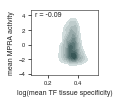

In [36]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(for_joint["log_avg_tf_tissue_sp"], for_joint["tile_mean_expr"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(mean TF tissue specificity)")

r, p = stats.spearmanr(for_joint["log_avg_tf_tissue_sp"], for_joint["tile_mean_expr"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
fig.savefig("Fig_3C_3.pdf", bbox_inches="tight", dpi="figure")

r: 0.0851904541668, spearman p: 9.38739678006e-05


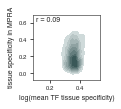

In [37]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(for_joint["log_avg_tf_tissue_sp"], for_joint["tile_tissue_sp"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(mean TF tissue specificity)")

r, p = stats.spearmanr(for_joint["log_avg_tf_tissue_sp"], for_joint["tile_tissue_sp"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
fig.savefig("Fig_3C_6.pdf", bbox_inches="tight", dpi="figure")

## number of bp covered

In [38]:
mean_activ.dropna(inplace=True)

r: 0.28149830273, spearman p: 1.70689654122e-39


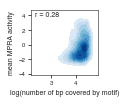

In [39]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(mean_activ["log_bp_cov"], mean_activ["tile_mean_expr"], cmap="Blues", 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(number of bp covered by motif)")

r, p = stats.spearmanr(mean_activ["log_bp_cov"], mean_activ["tile_mean_expr"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
fig.savefig("Fig_3C_1.pdf", bbox_inches="tight", dpi="figure")

r: -0.164330518614, spearman p: 3.66858885488e-14


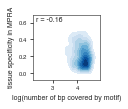

In [40]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(mean_activ["log_bp_cov"], mean_activ["tile_tissue_sp"], cmap="Blues", 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(number of bp covered by motif)")

r, p = stats.spearmanr(mean_activ["log_bp_cov"], mean_activ["tile_tissue_sp"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
fig.savefig("Fig_3C_4.pdf", bbox_inches="tight", dpi="figure")

## max coverage

In [41]:
cmap = sns.light_palette("firebrick", as_cmap=True)

r: 0.329209707519, spearman p: 3.43536181424e-54


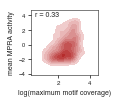

In [42]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(mean_activ["log_max_cov"], mean_activ["tile_mean_expr"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("mean MPRA activity")
ax.set_xlabel("log(maximum motif coverage)")

r, p = stats.spearmanr(mean_activ["log_max_cov"], mean_activ["tile_mean_expr"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
fig.savefig("Fig_3C_2.pdf", bbox_inches="tight", dpi="figure")

r: -0.246344610807, spearman p: 2.32313173595e-30


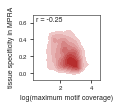

In [43]:
fig = plt.figure(figsize=(1.2, 1.2))
ax = sns.kdeplot(mean_activ["log_max_cov"], mean_activ["tile_tissue_sp"], cmap=cmap, 
                 shade=True, shade_lowest=False)
ax.set_ylabel("tissue specificity in MPRA")
ax.set_xlabel("log(maximum motif coverage)")

r, p = stats.spearmanr(mean_activ["log_max_cov"], mean_activ["tile_tissue_sp"])
print("r: %s, spearman p: %s" % (r, p))
ax.annotate("r = {:.2f}".format(r), xy=(.05, .9), xycoords=ax.transAxes, fontsize=fontsize)
fig.savefig("Fig_3C_5.pdf", bbox_inches="tight", dpi="figure")

## 7. write files

In [44]:
final = mean_activ[["unique_id", "tile_mean_expr", "tile_tissue_sp", "avg_tf_tissue_sp", "log_avg_tf_tissue_sp",
                    "numMotifs", "log_num_motifs", "numBPcovered", "log_bp_cov", "maxCov", "log_max_cov"]]
final.head()

,unique_id,tile_mean_expr,tile_tissue_sp,avg_tf_tissue_sp,log_avg_tf_tissue_sp,numMotifs,log_num_motifs,numBPcovered,log_bp_cov,maxCov,log_max_cov
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,-1.974712,0.386721,0.249383,0.222650,10,2.397895,45,3.828641,6,1.945910
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,-0.700792,0.165019,0.416909,0.348478,53,3.988984,101,4.624973,24,3.218876
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,-0.886722,0.261225,0.429598,0.357394,24,3.218876,84,4.442651,12,2.564949
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,-1.445209,0.265622,0.435871,0.361772,13,2.639057,54,4.007333,9,2.302585
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,-1.062973,0.117438,0.462181,0.379929,16,2.833213,99,4.605170,5,1.791759


In [45]:
final.columns = ["unique_id", "MPRA_mean_activ", "MPRA_tissue_sp", "avg_tf_tissue_sp", "log_avg_tf_tissue_sp",
                 "num_motifs", "log_num_motifs", "num_bp_covered", "log_num_bp_covered", "max_coverage",
                 "log_max_coverage"]
final.head()

,unique_id,MPRA_mean_activ,MPRA_tissue_sp,avg_tf_tissue_sp,log_avg_tf_tissue_sp,num_motifs,log_num_motifs,num_bp_covered,log_num_bp_covered,max_coverage,log_max_coverage
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,-1.974712,0.386721,0.249383,0.222650,10,2.397895,45,3.828641,6,1.945910
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,-0.700792,0.165019,0.416909,0.348478,53,3.988984,101,4.624973,24,3.218876
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,-0.886722,0.261225,0.429598,0.357394,24,3.218876,84,4.442651,12,2.564949
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,-1.445209,0.265622,0.435871,0.361772,13,2.639057,54,4.007333,9,2.302585
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,-1.062973,0.117438,0.462181,0.379929,16,2.833213,99,4.605170,5,1.791759


In [46]:
out_dir = "../../data/04__coverage"
!mkdir -p $out_dir
final.to_csv("%s/motif_coverage.txt" % out_dir, sep="\t", index=False)
tf_expr.to_csv("%s/tf_tissue_sp.txt" % out_dir, sep="\t", index=False)